# Multi-Class Hate Speech EDA: Arabic Text Analysis

## 📋 Overview
Comprehensive exploratory data analysis for Arabic hate speech classification across three polarization types:
- **Political** | **Religious** | **Racial/Ethnic**

## 🎯 Analysis Components
1. **Class Distribution** - Imbalance metrics and training strategies
2. **Linguistic Signatures** - Text length, code-switching, multilingual elements
3. **Statistical Testing** - Significance validation of observed patterns
4. **Vocabulary Analysis** - TF-IDF discriminative terms and overlap
5. **Sample Coverage** - Training set selection implications

---

## 📑 Navigation

**Part 1: Setup** → Import Libraries, Load Data

**Part 2: Distribution Analysis** → Class Balance, Co-occurrence, Coverage

**Part 3: Linguistic Analysis** → Features, Signatures, Statistical Tests

**Part 4: Vocabulary Analysis** → TF-IDF, Overlap, Lexicon Export

**Part 5: Summary** → Key Findings, Recommendations, Export

---

# Part 1: Setup & Data Loading
## 1.1 Import Libraries

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1.2 Load Dataset

In [2]:
# Load the dataset
DATA_PATH = "arb.csv"
df = pd.read_csv(DATA_PATH)

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"\nTotal samples: {len(df):,}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nFirst few rows:")
display(df.head())

DATASET OVERVIEW

Total samples: 3,380

Columns: ['id', 'text', 'political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

Data types:
id               object
text             object
political         int64
racial/ethnic     int64
religious         int64
gender/sexual     int64
other             int64
dtype: object

Missing values:
id               0
text             0
political        0
racial/ethnic    0
religious        0
gender/sexual    0
other            0
dtype: int64

First few rows:


,id,text,political,racial/ethnic,religious,gender/sexual,other
0,arb_a2a60c8b4af3389e842d8ec31afb0eea,احلام انتي ونعالي ومنو انتي حتى تقيمين الفناني...,0,0,0,1,1
1,arb_6723e56a672674a6c1d9b28b213c4a05,وره الكواليس تنيجج من وره بعير صطناعي على فكرة...,0,0,0,1,1
2,arb_b0365d606edeee38ae6c025b1ca33e96,.خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...,0,0,0,1,1
3,arb_858c0ee684049ba6f416a6cecb0b0761,الله يخزي احلام هي والبرنامج الخايس الي كله مصخره,0,0,0,1,1
4,arb_bdafc73afd0bc2cd2badae2a089446b9,كس ام احلام الي ماربتها وش ملكه هههه متستاهل م...,0,0,0,0,1


---
# Part 2: Class Distribution Analysis
## 2.1 Target Label Distribution

Quantifying class imbalance across Political, Religious, and Racial/Ethnic categories.

In [3]:
# Define the three polarization types of interest
POLARIZATION_TYPES = ['political', 'religious', 'racial/ethnic']

# Calculate class distributions
print("=" * 70)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 70)

distribution_stats = {}
for col in POLARIZATION_TYPES:
    positive_count = df[col].sum()
    negative_count = len(df) - positive_count
    positive_pct = (positive_count / len(df)) * 100
    
    distribution_stats[col] = {
        'positive': positive_count,
        'negative': negative_count,
        'positive_pct': positive_pct,
        'imbalance_ratio': negative_count / positive_count if positive_count > 0 else np.inf
    }
    
    print(f"\n{'─' * 70}")
    print(f"📊 {col.upper()}")
    print(f"{'─' * 70}")
    print(f"  Positive samples: {positive_count:,} ({positive_pct:.2f}%)")
    print(f"  Negative samples: {negative_count:,} ({100-positive_pct:.2f}%)")
    print(f"  Imbalance ratio: 1:{distribution_stats[col]['imbalance_ratio']:.2f}")

# Create summary DataFrame
summary_df = pd.DataFrame(distribution_stats).T
print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)
display(summary_df)

CLASS DISTRIBUTION ANALYSIS

──────────────────────────────────────────────────────────────────────
📊 POLITICAL
──────────────────────────────────────────────────────────────────────
  Positive samples: 780 (23.08%)
  Negative samples: 2,600 (76.92%)
  Imbalance ratio: 1:3.33

──────────────────────────────────────────────────────────────────────
📊 RELIGIOUS
──────────────────────────────────────────────────────────────────────
  Positive samples: 283 (8.37%)
  Negative samples: 3,097 (91.63%)
  Imbalance ratio: 1:10.94

──────────────────────────────────────────────────────────────────────
📊 RACIAL/ETHNIC
──────────────────────────────────────────────────────────────────────
  Positive samples: 583 (17.25%)
  Negative samples: 2,797 (82.75%)
  Imbalance ratio: 1:4.80

SUMMARY TABLE


,positive,negative,positive_pct,imbalance_ratio
political,780.0,2600.0,23.076923,3.333333
religious,283.0,3097.0,8.372781,10.943463
racial/ethnic,583.0,2797.0,17.248521,4.797599


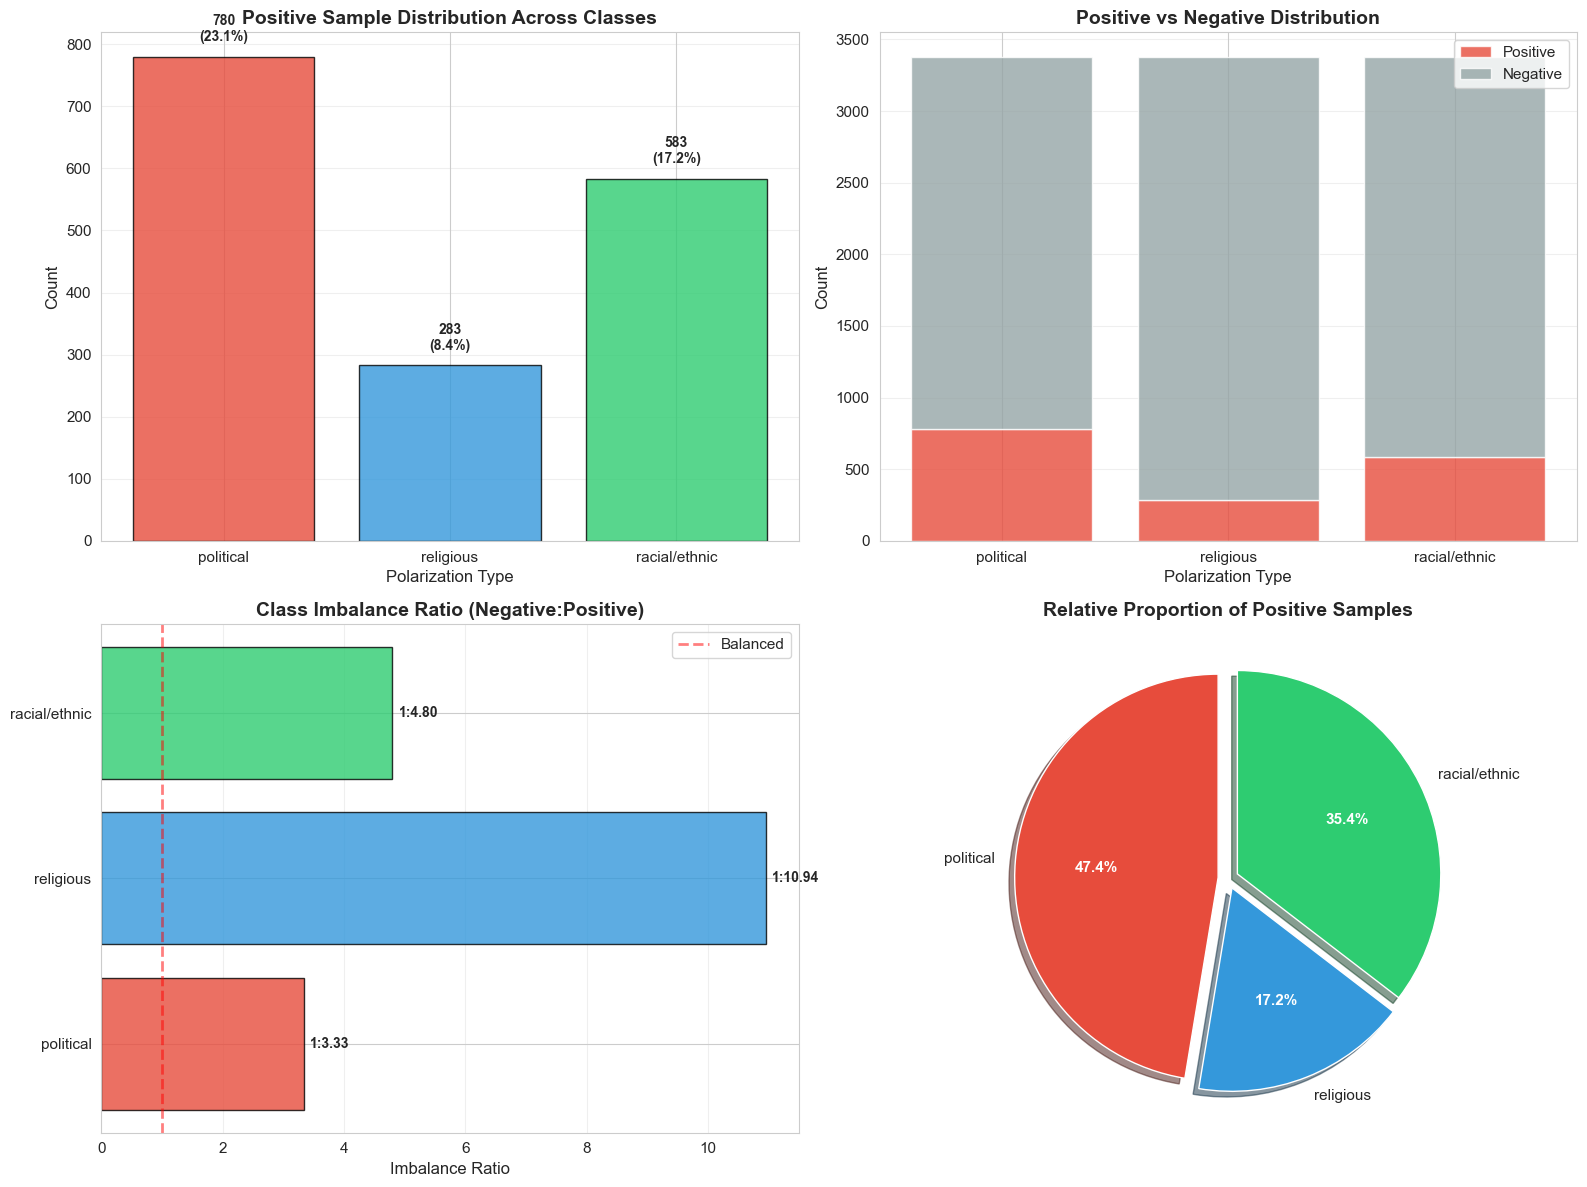


RECOMMENDED CLASS WEIGHTS FOR WEIGHTED LOSS

POLITICAL:
  Positive class weight: 2.1667
  Negative class weight: 0.6500

RELIGIOUS:
  Positive class weight: 5.9717
  Negative class weight: 0.5457

RACIAL/ETHNIC:
  Positive class weight: 2.8988
  Negative class weight: 0.6042


In [4]:
# Visualization: Class distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart comparing positive samples
ax1 = axes[0, 0]
positive_counts = [distribution_stats[col]['positive'] for col in POLARIZATION_TYPES]
colors = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax1.bar(POLARIZATION_TYPES, positive_counts, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Positive Sample Distribution Across Classes', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xlabel('Polarization Type', fontsize=12)
for i, (bar, count) in enumerate(zip(bars, positive_counts)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{count:,}\n({distribution_stats[POLARIZATION_TYPES[i]]["positive_pct"]:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 2. Stacked bar showing positive/negative split
ax2 = axes[0, 1]
positive_data = [distribution_stats[col]['positive'] for col in POLARIZATION_TYPES]
negative_data = [distribution_stats[col]['negative'] for col in POLARIZATION_TYPES]
x_pos = np.arange(len(POLARIZATION_TYPES))
ax2.bar(x_pos, positive_data, label='Positive', color='#e74c3c', alpha=0.8)
ax2.bar(x_pos, negative_data, bottom=positive_data, label='Negative', color='#95a5a6', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(POLARIZATION_TYPES)
ax2.set_title('Positive vs Negative Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Polarization Type', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

# 3. Imbalance ratio comparison
ax3 = axes[1, 0]
imbalance_ratios = [distribution_stats[col]['imbalance_ratio'] for col in POLARIZATION_TYPES]
bars = ax3.barh(POLARIZATION_TYPES, imbalance_ratios, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('Class Imbalance Ratio (Negative:Positive)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Imbalance Ratio', fontsize=12)
ax3.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Balanced')
for i, (bar, ratio) in enumerate(zip(bars, imbalance_ratios)):
    width = bar.get_width()
    ax3.text(width + 0.1, bar.get_y() + bar.get_height()/2.,
            f'1:{ratio:.2f}', ha='left', va='center', fontweight='bold', fontsize=10)
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Percentage distribution pie charts
ax4 = axes[1, 1]
positive_percentages = [distribution_stats[col]['positive_pct'] for col in POLARIZATION_TYPES]
wedges, texts, autotexts = ax4.pie(positive_percentages, labels=POLARIZATION_TYPES, 
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     explode=(0.05, 0.05, 0.05), shadow=True)
ax4.set_title('Relative Proportion of Positive Samples', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()

# Calculate and display recommended class weights for weighted loss
print("\n" + "=" * 70)
print("RECOMMENDED CLASS WEIGHTS FOR WEIGHTED LOSS")
print("=" * 70)
for col in POLARIZATION_TYPES:
    pos_weight = len(df) / (2 * distribution_stats[col]['positive'])
    neg_weight = len(df) / (2 * distribution_stats[col]['negative'])
    print(f"\n{col.upper()}:")
    print(f"  Positive class weight: {pos_weight:.4f}")
    print(f"  Negative class weight: {neg_weight:.4f}")

## 2.2 Multi-Label Co-occurrence

MULTI-LABEL CO-OCCURRENCE ANALYSIS

Label Count Distribution:
label_count
0    2284
1     634
2     374
3      88
Name: count, dtype: int64

──────────────────────────────────────────────────────────────────────
PAIRWISE CO-OCCURRENCE
──────────────────────────────────────────────────────────────────────

Political ∩ Religious: 169 samples

Political ∩ Racial/ethnic: 348 samples

Religious ∩ Racial/ethnic: 121 samples

All three labels: 88 samples


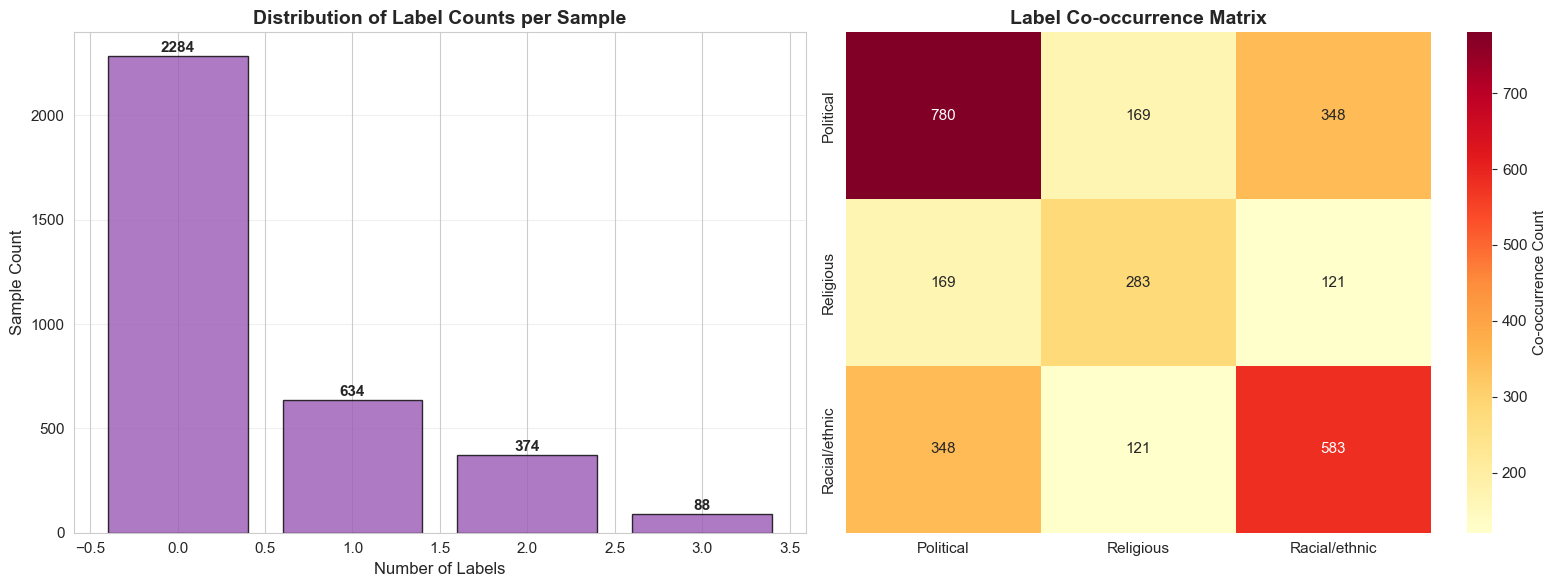

In [5]:
# Multi-label co-occurrence analysis
print("=" * 70)
print("MULTI-LABEL CO-OCCURRENCE ANALYSIS")
print("=" * 70)

# Count samples with multiple labels
df['label_count'] = df[POLARIZATION_TYPES].sum(axis=1)

print("\nLabel Count Distribution:")
print(df['label_count'].value_counts().sort_index())

# Pairwise co-occurrence
print("\n" + "─" * 70)
print("PAIRWISE CO-OCCURRENCE")
print("─" * 70)

from itertools import combinations
for col1, col2 in combinations(POLARIZATION_TYPES, 2):
    co_occur = ((df[col1] == 1) & (df[col2] == 1)).sum()
    print(f"\n{col1.capitalize()} ∩ {col2.capitalize()}: {co_occur} samples")

# All three labels
all_three = ((df['political'] == 1) & (df['religious'] == 1) & (df['racial/ethnic'] == 1)).sum()
print(f"\nAll three labels: {all_three} samples")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Label count distribution
ax1 = axes[0]
label_dist = df['label_count'].value_counts().sort_index()
ax1.bar(label_dist.index, label_dist.values, color='#9b59b6', alpha=0.8, edgecolor='black')
ax1.set_title('Distribution of Label Counts per Sample', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Labels', fontsize=12)
ax1.set_ylabel('Sample Count', fontsize=12)
for i, v in enumerate(label_dist.values):
    ax1.text(label_dist.index[i], v + 20, str(v), ha='center', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Co-occurrence heatmap
ax2 = axes[1]
co_occurrence_matrix = np.zeros((len(POLARIZATION_TYPES), len(POLARIZATION_TYPES)))
for i, col1 in enumerate(POLARIZATION_TYPES):
    for j, col2 in enumerate(POLARIZATION_TYPES):
        if i == j:
            co_occurrence_matrix[i, j] = distribution_stats[col1]['positive']
        else:
            co_occurrence_matrix[i, j] = ((df[col1] == 1) & (df[col2] == 1)).sum()

sns.heatmap(co_occurrence_matrix, annot=True, fmt='.0f', cmap='YlOrRd', 
            xticklabels=[c.capitalize() for c in POLARIZATION_TYPES],
            yticklabels=[c.capitalize() for c in POLARIZATION_TYPES],
            cbar_kws={'label': 'Co-occurrence Count'}, ax=ax2)
ax2.set_title('Label Co-occurrence Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 2.3 Sample Coverage Analysis

SAMPLE COVERAGE ANALYSIS

Analyzing dataset coverage for training set selection

──────────────────────────────────────────────────────────────────────
SAMPLES WITHOUT TARGET LABELS (Political, Religious, Racial/Ethnic)
──────────────────────────────────────────────────────────────────────
Count: 2,284 (67.57% of dataset)

Breakdown of samples WITHOUT any target label:
  • Gender/sexual only: 103 (3.05%)
  • Other only: 193 (5.71%)
  • Gender/sexual + Other: 120 (3.55%)
  • Neither (all zeros): 1,868 (55.27%)

──────────────────────────────────────────────────────────────────────
SAMPLES WITH AT LEAST ONE TARGET LABEL
──────────────────────────────────────────────────────────────────────
Count: 1,096 (32.43% of dataset)

──────────────────────────────────────────────────────────────────────
COMPLETE LABEL PATTERN DISTRIBUTION
──────────────────────────────────────────────────────────────────────

Top 10 most common label patterns:
Pattern                                     Count      

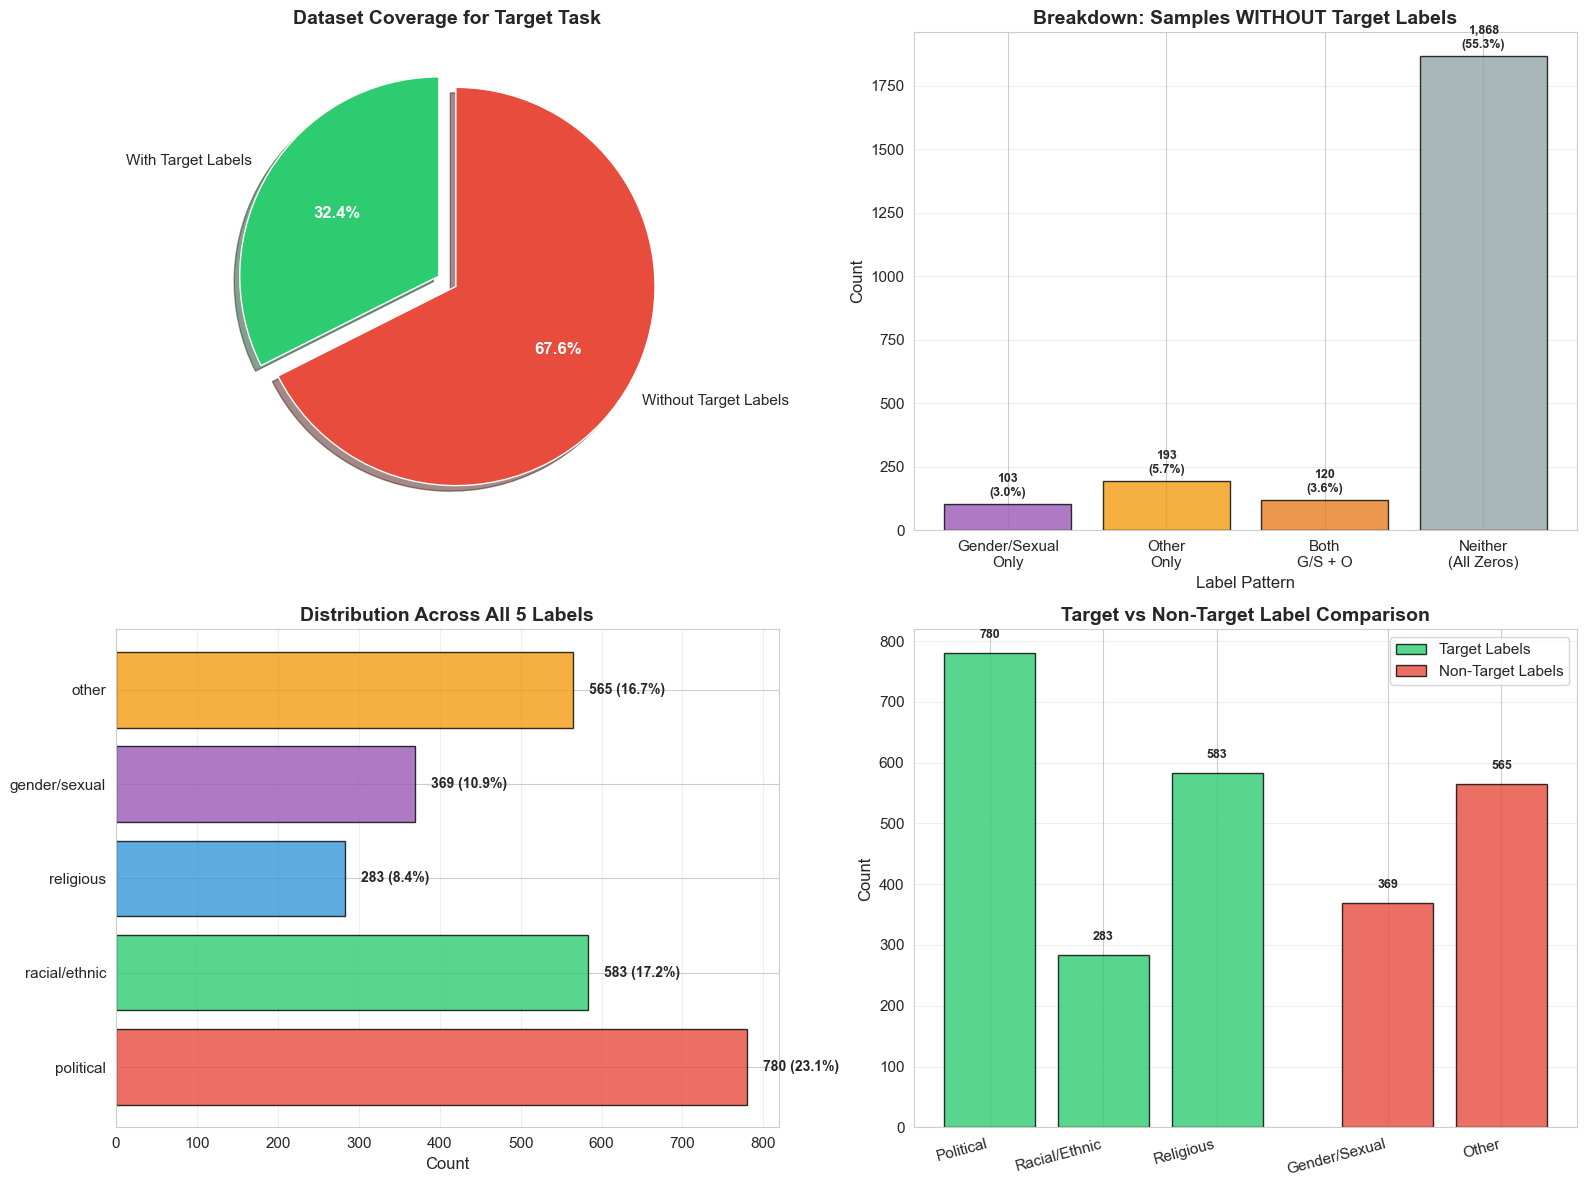

In [17]:
# Sample Coverage Analysis
print("=" * 70)
print("SAMPLE COVERAGE ANALYSIS")
print("=" * 70)
print("\nAnalyzing dataset coverage for training set selection")

# All available label columns
ALL_LABELS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']

# Samples with NONE of the 3 target labels
none_of_target = df[(df['political'] == 0) & (df['religious'] == 0) & (df['racial/ethnic'] == 0)]
print(f"\n{'─' * 70}")
print("SAMPLES WITHOUT TARGET LABELS (Political, Religious, Racial/Ethnic)")
print(f"{'─' * 70}")
print(f"Count: {len(none_of_target):,} ({len(none_of_target)/len(df)*100:.2f}% of dataset)")

# Breakdown of samples without target labels
print(f"\nBreakdown of samples WITHOUT any target label:")
none_gender_only = none_of_target[(none_of_target['gender/sexual'] == 1) & (none_of_target['other'] == 0)]
none_other_only = none_of_target[(none_of_target['gender/sexual'] == 0) & (none_of_target['other'] == 1)]
none_both = none_of_target[(none_of_target['gender/sexual'] == 1) & (none_of_target['other'] == 1)]
none_neither = none_of_target[(none_of_target['gender/sexual'] == 0) & (none_of_target['other'] == 0)]

print(f"  • Gender/sexual only: {len(none_gender_only):,} ({len(none_gender_only)/len(df)*100:.2f}%)")
print(f"  • Other only: {len(none_other_only):,} ({len(none_other_only)/len(df)*100:.2f}%)")
print(f"  • Gender/sexual + Other: {len(none_both):,} ({len(none_both)/len(df)*100:.2f}%)")
print(f"  • Neither (all zeros): {len(none_neither):,} ({len(none_neither)/len(df)*100:.2f}%)")

# Samples with AT LEAST ONE target label
with_target = df[(df['political'] == 1) | (df['religious'] == 1) | (df['racial/ethnic'] == 1)]
print(f"\n{'─' * 70}")
print("SAMPLES WITH AT LEAST ONE TARGET LABEL")
print(f"{'─' * 70}")
print(f"Count: {len(with_target):,} ({len(with_target)/len(df)*100:.2f}% of dataset)")

# Complete label distribution patterns
print(f"\n{'─' * 70}")
print("COMPLETE LABEL PATTERN DISTRIBUTION")
print(f"{'─' * 70}")

label_patterns = {}
for _, row in df.iterrows():
    pattern = tuple([int(row[label]) for label in ALL_LABELS])
    label_patterns[pattern] = label_patterns.get(pattern, 0) + 1

# Sort by frequency
sorted_patterns = sorted(label_patterns.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 10 most common label patterns:")
print(f"{'Pattern':<40} {'Count':>8} {'%':>7}")
print("─" * 60)
for i, (pattern, count) in enumerate(sorted_patterns[:10], 1):
    pattern_str = f"[P:{pattern[0]}, R/E:{pattern[1]}, Rel:{pattern[2]}, G/S:{pattern[3]}, O:{pattern[4]}]"
    print(f"{pattern_str:<40} {count:>8,} {count/len(df)*100:>6.2f}%")

# Training set implications
print(f"\n{'═' * 70}")
print("TRAINING SET SELECTION IMPLICATIONS")
print(f"{'═' * 70}")

print(f"\n1. USABLE SAMPLES FOR TARGET TASK:")
print(f"   {len(with_target):,} samples ({len(with_target)/len(df)*100:.2f}%)")
print(f"   → These have at least one of: Political, Religious, or Racial/Ethnic")

print(f"\n2. EXCLUDED SAMPLES:")
print(f"   {len(none_of_target):,} samples ({len(none_of_target)/len(df)*100:.2f}%)")
print(f"   → These lack all three target labels")

print(f"\n3. NON-TARGET LABELS ONLY:")
print(f"   Gender/sexual only: {len(none_gender_only):,}")
print(f"   Other only: {len(none_other_only):,}")
print(f"   Combined: {len(none_both):,}")
print(f"   → Consider using as negative examples or separate task")

print(f"\n4. RECOMMENDATION:")
if len(with_target) / len(df) > 0.5:
    print(f"   ✓ Sufficient target label coverage ({len(with_target)/len(df)*100:.1f}%)")
    print(f"   ✓ Proceed with target labels as primary task")
else:
    print(f"   ⚠ Limited target label coverage ({len(with_target)/len(df)*100:.1f}%)")
    print(f"   ⚠ Consider multi-task learning with all 5 labels")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Coverage pie chart
ax1 = axes[0, 0]
coverage_data = [len(with_target), len(none_of_target)]
coverage_labels = ['With Target Labels', 'Without Target Labels']
colors_coverage = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax1.pie(coverage_data, labels=coverage_labels, autopct='%1.1f%%',
                                     colors=colors_coverage, startangle=90, explode=(0.05, 0.05),
                                     shadow=True)
ax1.set_title('Dataset Coverage for Target Task', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# 2. Non-target label breakdown
ax2 = axes[0, 1]
non_target_data = [len(none_gender_only), len(none_other_only), len(none_both), len(none_neither)]
non_target_labels = ['Gender/Sexual\nOnly', 'Other\nOnly', 'Both\nG/S + O', 'Neither\n(All Zeros)']
colors_non = ['#9b59b6', '#f39c12', '#e67e22', '#95a5a6']
bars = ax2.bar(non_target_labels, non_target_data, color=colors_non, alpha=0.8, edgecolor='black')
ax2.set_title('Breakdown: Samples WITHOUT Target Labels', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xlabel('Label Pattern', fontsize=12)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{int(height):,}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. All labels distribution
ax3 = axes[1, 0]
all_label_counts = [df[label].sum() for label in ALL_LABELS]
colors_all = ['#e74c3c', '#2ecc71', '#3498db', '#9b59b6', '#f39c12']
bars = ax3.barh(ALL_LABELS, all_label_counts, color=colors_all, alpha=0.8, edgecolor='black')
ax3.set_title('Distribution Across All 5 Labels', fontsize=14, fontweight='bold')
ax3.set_xlabel('Count', fontsize=12)
for bar, count in zip(bars, all_label_counts):
    width = bar.get_width()
    ax3.text(width + 20, bar.get_y() + bar.get_height()/2.,
            f'{count:,} ({count/len(df)*100:.1f}%)',
            ha='left', va='center', fontweight='bold', fontsize=10)
ax3.grid(axis='x', alpha=0.3)

# 4. Target vs non-target comparison
ax4 = axes[1, 1]
target_labels = ['Political', 'Racial/Ethnic', 'Religious']
non_target_labels_chart = ['Gender/Sexual', 'Other']
target_counts = [df[label].sum() for label in POLARIZATION_TYPES]
non_target_counts = [df['gender/sexual'].sum(), df['other'].sum()]

x = np.arange(len(target_labels))
width = 0.8
bars1 = ax4.bar(x, target_counts, width, label='Target Labels', color='#2ecc71', alpha=0.8, edgecolor='black')

x2 = np.arange(len(non_target_labels_chart)) + len(target_labels) + 0.5
bars2 = ax4.bar(x2, non_target_counts, width, label='Non-Target Labels', color='#e74c3c', alpha=0.8, edgecolor='black')

ax4.set_title('Target vs Non-Target Label Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('Count', fontsize=12)
ax4.set_xticks(list(x) + list(x2))
ax4.set_xticklabels(target_labels + non_target_labels_chart, rotation=15, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 20,
                f'{int(height):,}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)

---
# Part 3: Linguistic Analysis
## 3.1 Feature Extraction

In [6]:
# Feature extraction functions
def extract_linguistic_features(text):
    """Extract linguistic features from Arabic text."""
    if pd.isna(text):
        return {
            'char_length': 0,
            'word_count': 0,
            'latin_chars': 0,
            'latin_char_ratio': 0,
            'digits': 0,
            'digit_ratio': 0,
            'has_multilingual': 0
        }
    
    text_str = str(text)
    char_length = len(text_str)
    word_count = len(text_str.split())
    
    # Count Latin characters (A-Z, a-z)
    latin_chars = len(re.findall(r'[A-Za-z]', text_str))
    latin_char_ratio = latin_chars / char_length if char_length > 0 else 0
    
    # Count Western digits
    digits = len(re.findall(r'[0-9]', text_str))
    digit_ratio = digits / char_length if char_length > 0 else 0
    
    # Has multilingual elements (code-switching indicator)
    has_multilingual = 1 if (latin_chars > 0 or digits > 0) else 0
    
    return {
        'char_length': char_length,
        'word_count': word_count,
        'latin_chars': latin_chars,
        'latin_char_ratio': latin_char_ratio,
        'digits': digits,
        'digit_ratio': digit_ratio,
        'has_multilingual': has_multilingual
    }

# Extract features for all texts
print("Extracting linguistic features...")
features = df['text'].apply(extract_linguistic_features)
feature_df = pd.DataFrame(features.tolist())

# Merge with original dataframe
df_analysis = pd.concat([df, feature_df], axis=1)

print("✓ Feature extraction complete")
print(f"\nFeatures extracted: {list(feature_df.columns)}")

Extracting linguistic features...
✓ Feature extraction complete

Features extracted: ['char_length', 'word_count', 'latin_chars', 'latin_char_ratio', 'digits', 'digit_ratio', 'has_multilingual']


## 3.2 Linguistic Signatures by Type

In [7]:
# Statistical comparison across polarization types
print("=" * 70)
print("LINGUISTIC SIGNATURES BY POLARIZATION TYPE")
print("=" * 70)

linguistic_features = ['char_length', 'word_count', 'latin_char_ratio', 'digit_ratio', 'has_multilingual']

comparison_stats = {}
for pol_type in POLARIZATION_TYPES:
    print(f"\n{'═' * 70}")
    print(f"📝 {pol_type.upper()}")
    print(f"{'═' * 70}")
    
    positive_samples = df_analysis[df_analysis[pol_type] == 1]
    negative_samples = df_analysis[df_analysis[pol_type] == 0]
    
    comparison_stats[pol_type] = {'positive': {}, 'negative': {}}
    
    for feature in linguistic_features:
        pos_mean = positive_samples[feature].mean()
        neg_mean = negative_samples[feature].mean()
        pos_std = positive_samples[feature].std()
        neg_std = negative_samples[feature].std()
        
        comparison_stats[pol_type]['positive'][feature] = {'mean': pos_mean, 'std': pos_std}
        comparison_stats[pol_type]['negative'][feature] = {'mean': neg_mean, 'std': neg_std}
        
        print(f"\n  {feature.replace('_', ' ').title()}:")
        print(f"    Positive: μ={pos_mean:.2f}, σ={pos_std:.2f}")
        print(f"    Negative: μ={neg_mean:.2f}, σ={neg_std:.2f}")
        print(f"    Difference: {pos_mean - neg_mean:+.2f} ({((pos_mean - neg_mean) / neg_mean * 100):+.1f}%)")

LINGUISTIC SIGNATURES BY POLARIZATION TYPE

══════════════════════════════════════════════════════════════════════
📝 POLITICAL
══════════════════════════════════════════════════════════════════════

  Char Length:
    Positive: μ=104.04, σ=40.30
    Negative: μ=92.34, σ=45.67
    Difference: +11.70 (+12.7%)

  Word Count:
    Positive: μ=18.19, σ=7.20
    Negative: μ=16.27, σ=8.20
    Difference: +1.92 (+11.8%)

  Latin Char Ratio:
    Positive: μ=0.00, σ=0.01
    Negative: μ=0.00, σ=0.01
    Difference: -0.00 (-64.6%)

  Digit Ratio:
    Positive: μ=0.00, σ=0.01
    Negative: μ=0.01, σ=0.02
    Difference: -0.00 (-77.7%)

  Has Multilingual:
    Positive: μ=0.05, σ=0.21
    Negative: μ=0.13, σ=0.33
    Difference: -0.08 (-63.2%)

══════════════════════════════════════════════════════════════════════
📝 RELIGIOUS
══════════════════════════════════════════════════════════════════════

  Char Length:
    Positive: μ=101.39, σ=35.58
    Negative: μ=94.46, σ=45.46
    Difference: +6.93 (+7.

## 3.3 Statistical Significance Testing

STATISTICAL SIGNIFICANCE TESTING

Testing whether observed differences are statistically significant
H0 (Null Hypothesis): No difference between positive and negative samples
α = 0.05 (significance level)

══════════════════════════════════════════════════════════════════════
📊 POLITICAL - STATISTICAL TESTS
══════════════════════════════════════════════════════════════════════

  T-TESTS (Continuous Features):
  ──────────────────────────────────────────────────────────────────

  Char Length:
    t-statistic: 6.4425
    p-value: 0.000000 ✓ SIGNIFICANT
    Cohen's d: 0.2717 (small effect)

  Word Count:
    t-statistic: 5.9030
    p-value: 0.000000 ✓ SIGNIFICANT
    Cohen's d: 0.2492 (small effect)

  Latin Char Ratio:
    t-statistic: -1.7696
    p-value: 0.076881 ✗ Not significant
    Cohen's d: -0.0839 (negligible effect)

  Digit Ratio:
    t-statistic: -5.9503
    p-value: 0.000000 ✓ SIGNIFICANT
    Cohen's d: -0.2888 (small effect)

  CHI-SQUARE TESTS (Categorical Features):
  ──

,Polarization Type,Feature,P-Value,Significant,Effect Size
0,Political,Char Length,1.341700e-10,✓,Small
1,Political,Word Count,3.921862e-09,✓,Small
2,Political,Latin Char Ratio,7.688102e-02,✗,Negligible
3,Political,Digit Ratio,2.950193e-09,✓,Small
4,Political,Has Multilingual,5.303920e-10,✓,Small
5,Religious,Char Length,1.262935e-02,✓,Negligible
6,Religious,Word Count,3.156995e-02,✓,Negligible
7,Religious,Latin Char Ratio,1.714732e-01,✗,Negligible
8,Religious,Digit Ratio,1.241672e-04,✓,Small
9,Religious,Has Multilingual,2.929681e-05,✓,Negligible


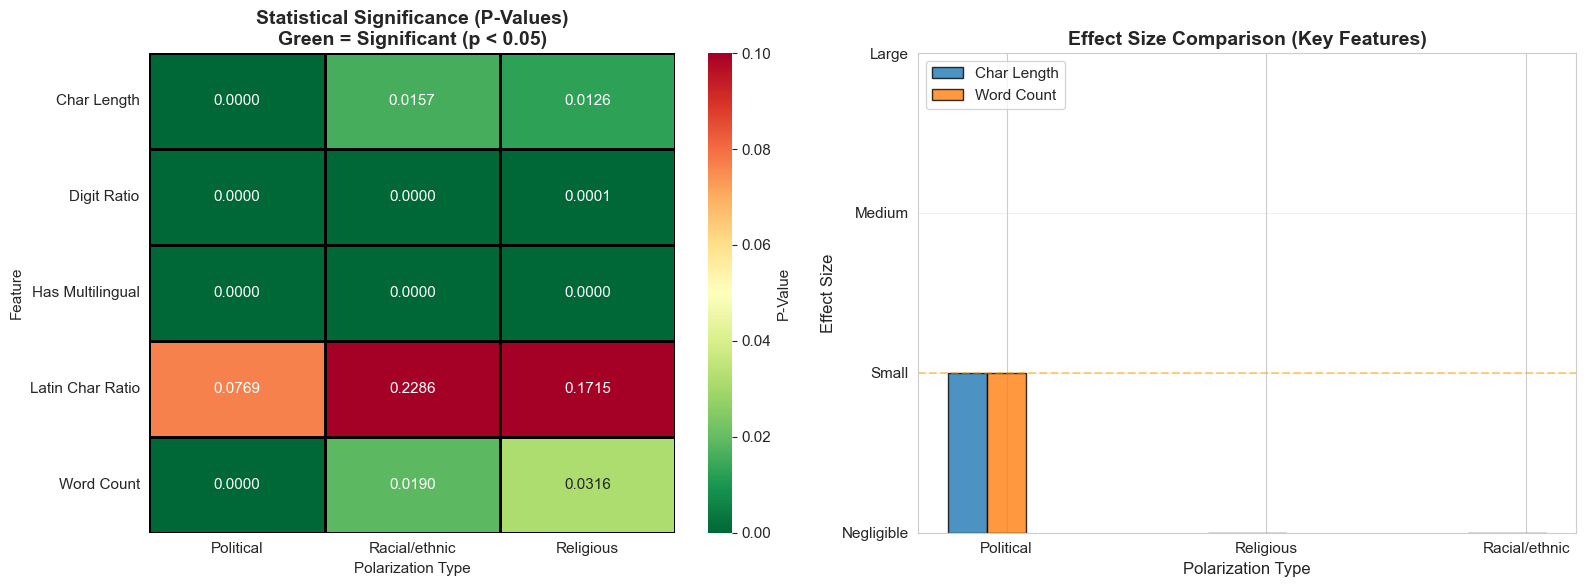


KEY INTERPRETATION NOTES:
• p < 0.05: Difference is statistically significant (reject H0)
• Cohen's d / Cramér's V: Measures practical significance (effect size)
• Effect sizes: Negligible < Small < Medium < Large
• Statistical significance ≠ practical importance
  → A feature can be significant but have negligible effect size


In [16]:
# Statistical Significance Testing
print("=" * 70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 70)
print("\nTesting whether observed differences are statistically significant")
print("H0 (Null Hypothesis): No difference between positive and negative samples")
print("α = 0.05 (significance level)")

from scipy import stats

# Store significance test results
significance_results = {}

# Continuous features: Use independent t-test
continuous_features = ['char_length', 'word_count', 'latin_char_ratio', 'digit_ratio']

# Categorical features: Use chi-square test
categorical_features = ['has_multilingual']

for pol_type in POLARIZATION_TYPES:
    print(f"\n{'═' * 70}")
    print(f"📊 {pol_type.upper()} - STATISTICAL TESTS")
    print(f"{'═' * 70}")
    
    positive_samples = df_analysis[df_analysis[pol_type] == 1]
    negative_samples = df_analysis[df_analysis[pol_type] == 0]
    
    significance_results[pol_type] = {}
    
    # T-tests for continuous features
    print(f"\n  T-TESTS (Continuous Features):")
    print(f"  {'─' * 66}")
    
    for feature in continuous_features:
        pos_data = positive_samples[feature].dropna()
        neg_data = negative_samples[feature].dropna()
        
        # Perform independent t-test
        t_stat, p_value = stats.ttest_ind(pos_data, neg_data)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt((pos_data.std()**2 + neg_data.std()**2) / 2)
        cohens_d = (pos_data.mean() - neg_data.mean()) / pooled_std if pooled_std > 0 else 0
        
        # Interpret results
        is_significant = p_value < 0.05
        significance_marker = "✓ SIGNIFICANT" if is_significant else "✗ Not significant"
        
        # Effect size interpretation
        if abs(cohens_d) < 0.2:
            effect_size = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size = "small"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        
        significance_results[pol_type][feature] = {
            't_stat': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'is_significant': is_significant,
            'effect_size': effect_size
        }
        
        print(f"\n  {feature.replace('_', ' ').title()}:")
        print(f"    t-statistic: {t_stat:.4f}")
        print(f"    p-value: {p_value:.6f} {significance_marker}")
        print(f"    Cohen's d: {cohens_d:.4f} ({effect_size} effect)")
    
    # Chi-square test for categorical features
    print(f"\n  CHI-SQUARE TESTS (Categorical Features):")
    print(f"  {'─' * 66}")
    
    for feature in categorical_features:
        # Create contingency table
        contingency_table = pd.crosstab(
            df_analysis[pol_type],
            df_analysis[feature]
        )
        
        # Perform chi-square test
        chi2_stat, p_value, dof, expected_freq = stats.chi2_contingency(contingency_table)
        
        # Calculate Cramér's V (effect size for chi-square)
        n = contingency_table.sum().sum()
        cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
        
        # Interpret results
        is_significant = p_value < 0.05
        significance_marker = "✓ SIGNIFICANT" if is_significant else "✗ Not significant"
        
        # Effect size interpretation for Cramér's V
        if cramers_v < 0.1:
            effect_size = "negligible"
        elif cramers_v < 0.3:
            effect_size = "small"
        elif cramers_v < 0.5:
            effect_size = "medium"
        else:
            effect_size = "large"
        
        significance_results[pol_type][feature] = {
            'chi2_stat': chi2_stat,
            'p_value': p_value,
            'cramers_v': cramers_v,
            'is_significant': is_significant,
            'effect_size': effect_size
        }
        
        print(f"\n  {feature.replace('_', ' ').title()}:")
        print(f"    χ² statistic: {chi2_stat:.4f}")
        print(f"    p-value: {p_value:.6f} {significance_marker}")
        print(f"    Cramér's V: {cramers_v:.4f} ({effect_size} effect)")
        print(f"\n    Contingency Table:")
        print(f"    {contingency_table}")

# Summary visualization
print("\n" + "=" * 70)
print("SIGNIFICANCE TESTING SUMMARY")
print("=" * 70)

# Create summary dataframe
summary_data = []
for pol_type in POLARIZATION_TYPES:
    for feature in continuous_features + categorical_features:
        result = significance_results[pol_type][feature]
        summary_data.append({
            'Polarization Type': pol_type.capitalize(),
            'Feature': feature.replace('_', ' ').title(),
            'P-Value': result['p_value'],
            'Significant': '✓' if result['is_significant'] else '✗',
            'Effect Size': result['effect_size'].capitalize()
        })

summary_df_sig = pd.DataFrame(summary_data)
print("\n")
display(summary_df_sig)

# Visualize significance results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. P-value heatmap
ax1 = axes[0]
pivot_pvalues = summary_df_sig.pivot(index='Feature', columns='Polarization Type', values='P-Value')
sns.heatmap(pivot_pvalues, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            vmin=0, vmax=0.1, cbar_kws={'label': 'P-Value'},
            linewidths=1, linecolor='black', ax=ax1)
ax1.set_title('Statistical Significance (P-Values)\nGreen = Significant (p < 0.05)', 
              fontsize=14, fontweight='bold')
ax1.axhline(y=0, color='black', linewidth=2)
ax1.axhline(y=len(pivot_pvalues), color='black', linewidth=2)
ax1.axvline(x=0, color='black', linewidth=2)
ax1.axvline(x=len(pivot_pvalues.columns), color='black', linewidth=2)

# 2. Effect size comparison
ax2 = axes[1]
effect_size_order = {'Negligible': 0, 'Small': 1, 'Medium': 2, 'Large': 3}
summary_df_sig['Effect_Numeric'] = summary_df_sig['Effect Size'].map(effect_size_order)

# Group data for visualization
grouped_data = summary_df_sig.groupby(['Polarization Type', 'Feature'])['Effect_Numeric'].first().unstack()
x_positions = np.arange(len(POLARIZATION_TYPES))
width = 0.15
features_to_plot = continuous_features[:2]  # Plot top 2 continuous features

for i, feature in enumerate(features_to_plot):
    feature_label = feature.replace('_', ' ').title()
    if feature_label in grouped_data.columns:
        values = [grouped_data.loc[pt.capitalize(), feature_label] if feature_label in grouped_data.columns else 0 
                  for pt in POLARIZATION_TYPES]
        ax2.bar(x_positions + i*width, values, width, 
                label=feature_label, alpha=0.8, edgecolor='black')

ax2.set_ylabel('Effect Size', fontsize=12)
ax2.set_xlabel('Polarization Type', fontsize=12)
ax2.set_title('Effect Size Comparison (Key Features)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_positions + width)
ax2.set_xticklabels([pt.capitalize() for pt in POLARIZATION_TYPES])
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['Negligible', 'Small', 'Medium', 'Large'])
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='Small threshold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("KEY INTERPRETATION NOTES:")
print("=" * 70)
print("• p < 0.05: Difference is statistically significant (reject H0)")
print("• Cohen's d / Cramér's V: Measures practical significance (effect size)")
print("• Effect sizes: Negligible < Small < Medium < Large")
print("• Statistical significance ≠ practical importance")
print("  → A feature can be significant but have negligible effect size")

## 3.4 Visualizations

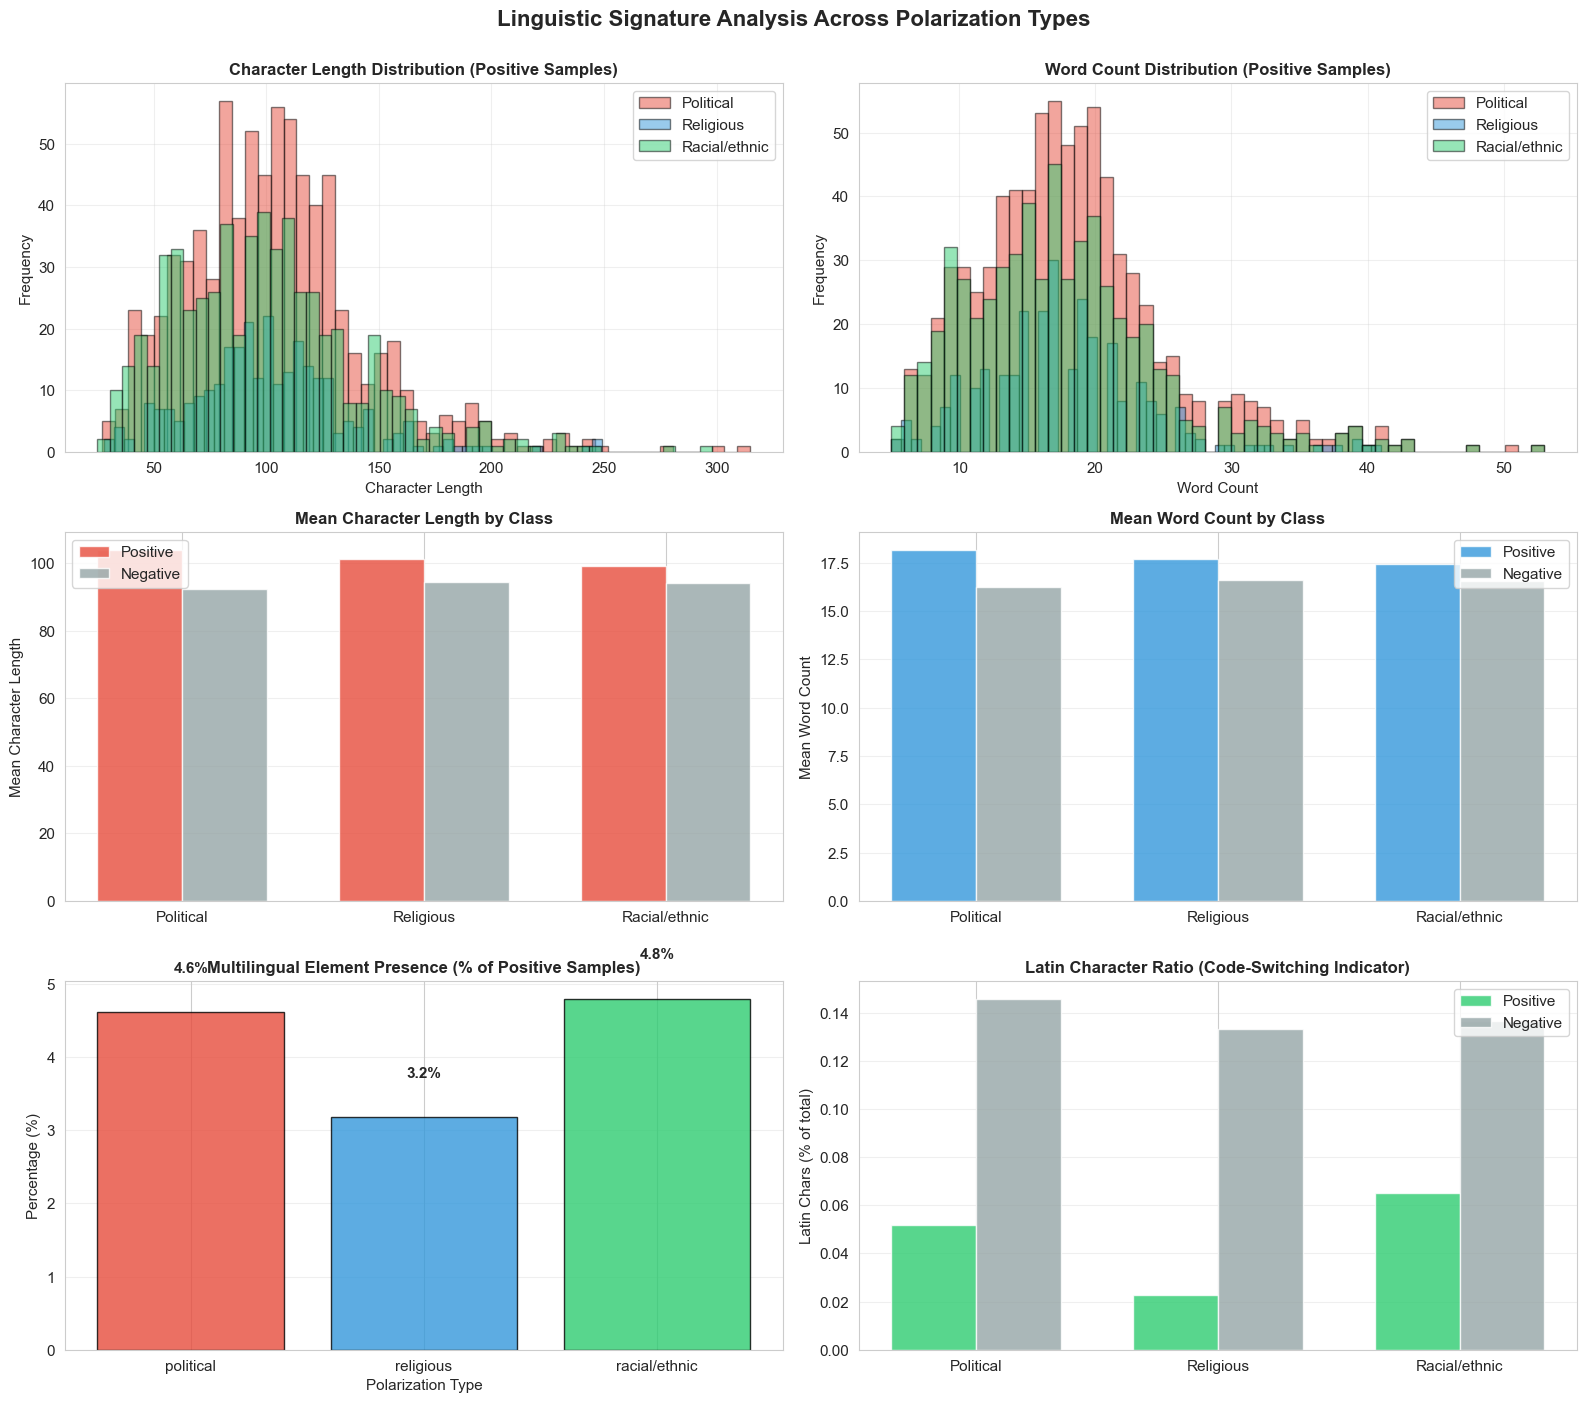


KEY INSIGHTS: CODE-SWITCHING PATTERNS

POLITICAL:
  Latin character ratio: 0.05%
  Samples with multilingual elements: 4.6%

RELIGIOUS:
  Latin character ratio: 0.02%
  Samples with multilingual elements: 3.2%

RACIAL/ETHNIC:
  Latin character ratio: 0.06%
  Samples with multilingual elements: 4.8%


In [8]:
# Comprehensive visualization of linguistic signatures
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Linguistic Signature Analysis Across Polarization Types', fontsize=16, fontweight='bold', y=1.0)

colors_pol = {'political': '#e74c3c', 'religious': '#3498db', 'racial/ethnic': '#2ecc71'}

# 1. Character Length Distribution
ax1 = axes[0, 0]
for pol_type in POLARIZATION_TYPES:
    positive_data = df_analysis[df_analysis[pol_type] == 1]['char_length']
    ax1.hist(positive_data, bins=50, alpha=0.5, label=pol_type.capitalize(), 
             color=colors_pol[pol_type], edgecolor='black')
ax1.set_title('Character Length Distribution (Positive Samples)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Character Length')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Word Count Distribution
ax2 = axes[0, 1]
for pol_type in POLARIZATION_TYPES:
    positive_data = df_analysis[df_analysis[pol_type] == 1]['word_count']
    ax2.hist(positive_data, bins=50, alpha=0.5, label=pol_type.capitalize(), 
             color=colors_pol[pol_type], edgecolor='black')
ax2.set_title('Word Count Distribution (Positive Samples)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Mean Character Length Comparison
ax3 = axes[1, 0]
pos_means = [comparison_stats[pt]['positive']['char_length']['mean'] for pt in POLARIZATION_TYPES]
neg_means = [comparison_stats[pt]['negative']['char_length']['mean'] for pt in POLARIZATION_TYPES]
x = np.arange(len(POLARIZATION_TYPES))
width = 0.35
ax3.bar(x - width/2, pos_means, width, label='Positive', color='#e74c3c', alpha=0.8)
ax3.bar(x + width/2, neg_means, width, label='Negative', color='#95a5a6', alpha=0.8)
ax3.set_title('Mean Character Length by Class', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean Character Length')
ax3.set_xticks(x)
ax3.set_xticklabels([pt.capitalize() for pt in POLARIZATION_TYPES])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Mean Word Count Comparison
ax4 = axes[1, 1]
pos_means = [comparison_stats[pt]['positive']['word_count']['mean'] for pt in POLARIZATION_TYPES]
neg_means = [comparison_stats[pt]['negative']['word_count']['mean'] for pt in POLARIZATION_TYPES]
ax4.bar(x - width/2, pos_means, width, label='Positive', color='#3498db', alpha=0.8)
ax4.bar(x + width/2, neg_means, width, label='Negative', color='#95a5a6', alpha=0.8)
ax4.set_title('Mean Word Count by Class', fontsize=12, fontweight='bold')
ax4.set_ylabel('Mean Word Count')
ax4.set_xticks(x)
ax4.set_xticklabels([pt.capitalize() for pt in POLARIZATION_TYPES])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Multilingual Element Presence
ax5 = axes[2, 0]
multilingual_pct = []
for pol_type in POLARIZATION_TYPES:
    positive_samples = df_analysis[df_analysis[pol_type] == 1]
    pct = (positive_samples['has_multilingual'].sum() / len(positive_samples)) * 100
    multilingual_pct.append(pct)
bars = ax5.bar(POLARIZATION_TYPES, multilingual_pct, color=[colors_pol[pt] for pt in POLARIZATION_TYPES], 
               alpha=0.8, edgecolor='black')
ax5.set_title('Multilingual Element Presence (% of Positive Samples)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Percentage (%)')
ax5.set_xlabel('Polarization Type')
for bar, pct in zip(bars, multilingual_pct):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# 6. Latin Character Ratio Comparison
ax6 = axes[2, 1]
pos_means = [comparison_stats[pt]['positive']['latin_char_ratio']['mean'] * 100 for pt in POLARIZATION_TYPES]
neg_means = [comparison_stats[pt]['negative']['latin_char_ratio']['mean'] * 100 for pt in POLARIZATION_TYPES]
ax6.bar(x - width/2, pos_means, width, label='Positive', color='#2ecc71', alpha=0.8)
ax6.bar(x + width/2, neg_means, width, label='Negative', color='#95a5a6', alpha=0.8)
ax6.set_title('Latin Character Ratio (Code-Switching Indicator)', fontsize=12, fontweight='bold')
ax6.set_ylabel('Latin Chars (% of total)')
ax6.set_xticks(x)
ax6.set_xticklabels([pt.capitalize() for pt in POLARIZATION_TYPES])
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance insights
print("\n" + "=" * 70)
print("KEY INSIGHTS: CODE-SWITCHING PATTERNS")
print("=" * 70)
for pol_type in POLARIZATION_TYPES:
    pos_samples = df_analysis[df_analysis[pol_type] == 1]
    latin_ratio = pos_samples['latin_char_ratio'].mean() * 100
    multilingual_pct = (pos_samples['has_multilingual'].sum() / len(pos_samples)) * 100
    print(f"\n{pol_type.upper()}:")
    print(f"  Latin character ratio: {latin_ratio:.2f}%")
    print(f"  Samples with multilingual elements: {multilingual_pct:.1f}%")

---
# Part 4: Vocabulary Analysis  
## 4.1 Data Preparation

In [9]:
# Prepare data for TF-IDF analysis
def get_class_texts(df, class_name):
    """Extract texts for a specific class."""
    return df[df[class_name] == 1]['text'].dropna().astype(str).tolist()

# Extract texts for each polarization type
class_texts = {}
for pol_type in POLARIZATION_TYPES:
    class_texts[pol_type] = get_class_texts(df_analysis, pol_type)
    print(f"{pol_type.capitalize()}: {len(class_texts[pol_type])} texts")

Political: 780 texts
Religious: 283 texts
Racial/ethnic: 583 texts


## 4.2 TF-IDF: Unigrams

In [10]:
# TF-IDF Analysis: Unigrams (single words)
print("=" * 70)
print("TF-IDF ANALYSIS: TOP DISCRIMINATIVE UNIGRAMS")
print("=" * 70)

# Initialize TF-IDF vectorizer for unigrams
tfidf_unigram = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 1),
    min_df=2,
    max_df=0.95
)

unigram_results = {}

for pol_type in POLARIZATION_TYPES:
    print(f"\n{'═' * 70}")
    print(f"🔍 {pol_type.upper()} - TOP 20 UNIGRAMS")
    print(f"{'═' * 70}")
    
    # Fit TF-IDF
    tfidf_matrix = tfidf_unigram.fit_transform(class_texts[pol_type])
    feature_names = tfidf_unigram.get_feature_names_out()
    
    # Calculate mean TF-IDF scores
    mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top words
    top_indices = mean_tfidf.argsort()[-20:][::-1]
    top_words = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
    
    unigram_results[pol_type] = top_words
    
    # Display results
    for rank, (word, score) in enumerate(top_words, 1):
        print(f"{rank:2d}. {word:30s} (TF-IDF: {score:.4f})")

print("\n" + "=" * 70)

TF-IDF ANALYSIS: TOP DISCRIMINATIVE UNIGRAMS

══════════════════════════════════════════════════════════════════════
🔍 POLITICAL - TOP 20 UNIGRAMS
══════════════════════════════════════════════════════════════════════
 1. من                             (TF-IDF: 0.1023)
 2. في                             (TF-IDF: 0.0856)
 3. على                            (TF-IDF: 0.0718)
 4. لا                             (TF-IDF: 0.0441)
 5. الله                           (TF-IDF: 0.0408)
 6. يا                             (TF-IDF: 0.0394)
 7. ما                             (TF-IDF: 0.0364)
 8. كل                             (TF-IDF: 0.0346)
 9. مع                             (TF-IDF: 0.0310)
10. عن                             (TF-IDF: 0.0296)
11. سوريا                          (TF-IDF: 0.0241)
12. هذا                            (TF-IDF: 0.0227)
13. هي                             (TF-IDF: 0.0213)
14. ان                             (TF-IDF: 0.0206)
15. العرب                          (TF-IDF: 0.0202)
16

## 4.3 TF-IDF: Bigrams

In [11]:
# TF-IDF Analysis: Bigrams (2-word phrases)
print("=" * 70)
print("TF-IDF ANALYSIS: TOP DISCRIMINATIVE BIGRAMS")
print("=" * 70)

# Initialize TF-IDF vectorizer for bigrams
tfidf_bigram = TfidfVectorizer(
    max_features=100,
    ngram_range=(2, 2),
    min_df=2,
    max_df=0.95
)

bigram_results = {}

for pol_type in POLARIZATION_TYPES:
    print(f"\n{'═' * 70}")
    print(f"🔍 {pol_type.upper()} - TOP 15 BIGRAMS")
    print(f"{'═' * 70}")
    
    # Fit TF-IDF
    tfidf_matrix = tfidf_bigram.fit_transform(class_texts[pol_type])
    feature_names = tfidf_bigram.get_feature_names_out()
    
    # Calculate mean TF-IDF scores
    mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    
    # Get top bigrams
    top_indices = mean_tfidf.argsort()[-15:][::-1]
    top_bigrams = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
    
    bigram_results[pol_type] = top_bigrams
    
    # Display results
    for rank, (bigram, score) in enumerate(top_bigrams, 1):
        print(f"{rank:2d}. {bigram:40s} (TF-IDF: {score:.4f})")

print("\n" + "=" * 70)

TF-IDF ANALYSIS: TOP DISCRIMINATIVE BIGRAMS

══════════════════════════════════════════════════════════════════════
🔍 POLITICAL - TOP 15 BIGRAMS
══════════════════════════════════════════════════════════════════════
 1. الدولة العميقة                           (TF-IDF: 0.0189)
 2. فلول النظام                              (TF-IDF: 0.0124)
 3. الصحراء الغربية                          (TF-IDF: 0.0111)
 4. أحمد الشرع                               (TF-IDF: 0.0084)
 5. في سوريا                                 (TF-IDF: 0.0076)
 6. دول الخليج                               (TF-IDF: 0.0073)
 7. ثورة الجياع                              (TF-IDF: 0.0064)
 8. من قبل                                   (TF-IDF: 0.0060)
 9. في مصر                                   (TF-IDF: 0.0060)
10. اكثر من                                  (TF-IDF: 0.0059)
11. النظام البائد                            (TF-IDF: 0.0053)
12. يا حبيبي                                 (TF-IDF: 0.0053)
13. ونعم الوكيل                         

## 4.4 TF-IDF: Trigrams

In [12]:
# TF-IDF Analysis: Trigrams (3-word phrases)
print("=" * 70)
print("TF-IDF ANALYSIS: TOP DISCRIMINATIVE TRIGRAMS")
print("=" * 70)

# Initialize TF-IDF vectorizer for trigrams
tfidf_trigram = TfidfVectorizer(
    max_features=100,
    ngram_range=(3, 3),
    min_df=2,
    max_df=0.95
)

trigram_results = {}

for pol_type in POLARIZATION_TYPES:
    print(f"\n{'═' * 70}")
    print(f"🔍 {pol_type.upper()} - TOP 10 TRIGRAMS")
    print(f"{'═' * 70}")
    
    try:
        # Fit TF-IDF
        tfidf_matrix = tfidf_trigram.fit_transform(class_texts[pol_type])
        feature_names = tfidf_trigram.get_feature_names_out()
        
        # Calculate mean TF-IDF scores
        mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
        
        # Get top trigrams
        top_indices = mean_tfidf.argsort()[-10:][::-1]
        top_trigrams = [(feature_names[i], mean_tfidf[i]) for i in top_indices]
        
        trigram_results[pol_type] = top_trigrams
        
        # Display results
        for rank, (trigram, score) in enumerate(top_trigrams, 1):
            print(f"{rank:2d}. {trigram:50s} (TF-IDF: {score:.4f})")
    except:
        print(f"  Not enough trigrams found for {pol_type}")
        trigram_results[pol_type] = []

print("\n" + "=" * 70)

TF-IDF ANALYSIS: TOP DISCRIMINATIVE TRIGRAMS

══════════════════════════════════════════════════════════════════════
🔍 POLITICAL - TOP 10 TRIGRAMS
══════════════════════════════════════════════════════════════════════
 1. فلول النظام البائد                                 (TF-IDF: 0.0056)
 2. الله ونعم الوكيل                                   (TF-IDF: 0.0047)
 3. الدولة العميقة في                                  (TF-IDF: 0.0038)
 4. قانون الأمن الغذائي                                (TF-IDF: 0.0035)
 5. في السوق السوداء                                   (TF-IDF: 0.0026)
 6. اعداء الاسلام والمسلمين                            (TF-IDF: 0.0026)
 7. اكثر من مرة                                        (TF-IDF: 0.0026)
 8. الأفارقة فغير مرحب                                 (TF-IDF: 0.0026)
 9. الأقليات في سوريا                                  (TF-IDF: 0.0026)
10. الحرب في أوكرانيا                                  (TF-IDF: 0.0026)

═════════════════════════════════════════════════════════════

## 4.5 Visualizations

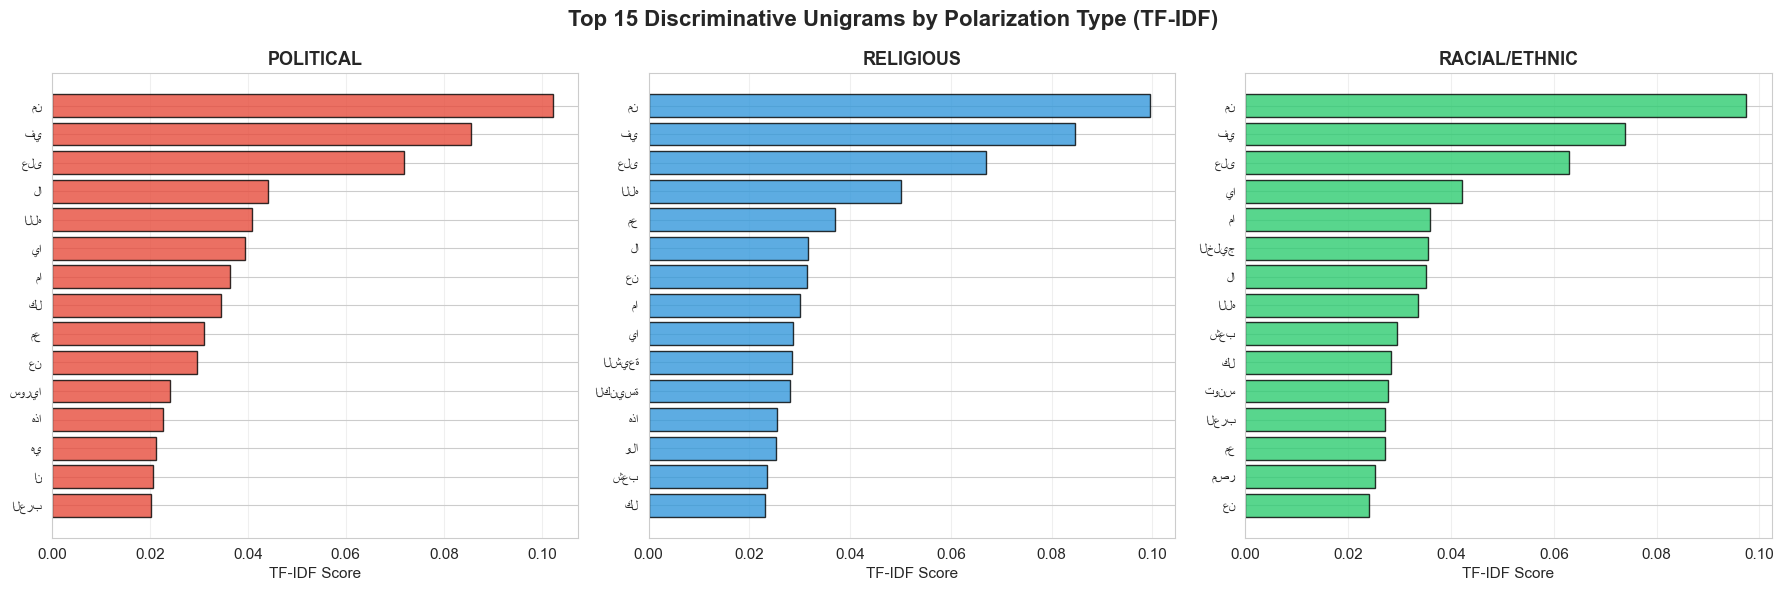

In [13]:
# Visualize top discriminative words
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Top 15 Discriminative Unigrams by Polarization Type (TF-IDF)', 
             fontsize=16, fontweight='bold')

for idx, pol_type in enumerate(POLARIZATION_TYPES):
    ax = axes[idx]
    
    # Get top 15 words
    top_15 = unigram_results[pol_type][:15]
    words = [w[0] for w in top_15]
    scores = [w[1] for w in top_15]
    
    # Create horizontal bar plot
    y_pos = np.arange(len(words))
    ax.barh(y_pos, scores, color=colors_pol[pol_type], alpha=0.8, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('TF-IDF Score', fontsize=11)
    ax.set_title(f'{pol_type.upper()}', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 4.6 Vocabulary Overlap Analysis

VOCABULARY OVERLAP ANALYSIS

Identifying shared and unique discriminative terms

──────────────────────────────────────────────────────────────────────
PAIRWISE VOCABULARY OVERLAP (Top 50 words)
──────────────────────────────────────────────────────────────────────

Overlap Matrix (Word Count):
                          Political      Religious  Racial/ethnic
─────────────────────────────────────────────────────────────────
Political                        20          12 (24%)          15 (30%)
Religious                     12 (24%)             20          13 (26%)
Racial/ethnic                 15 (30%)          13 (26%)             20

──────────────────────────────────────────────────────────────────────
AMBIGUOUS TERMS (Shared Across Classes)
──────────────────────────────────────────────────────────────────────

Words appearing in multiple classes: 16
Words appearing in all 3 classes: 12
Words appearing in exactly 2 classes: 4

Top Ambiguous Words (by number of classes):
   1. 'كل'

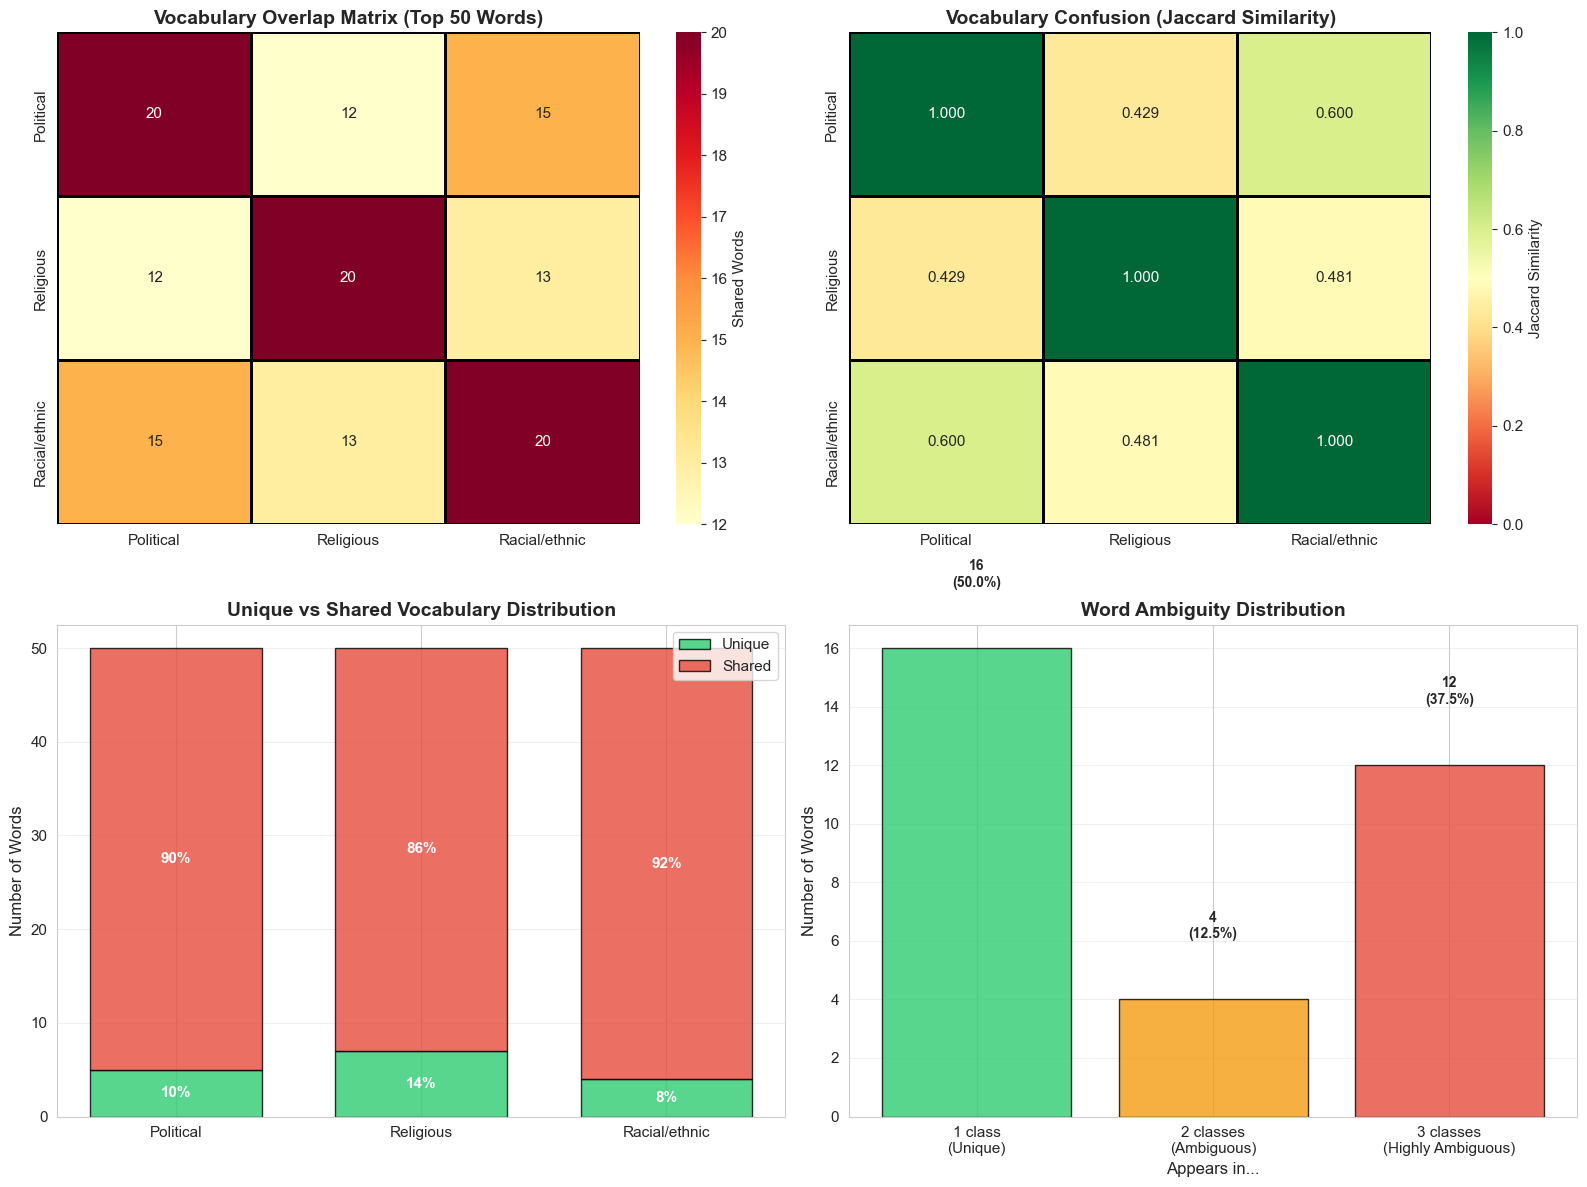


VOCABULARY ANALYSIS SUMMARY

📊 STATISTICS:
  Total unique words analyzed: 32
  Class-specific (unique) words: 16 (50.0%)
  Ambiguous words: 16 (50.0%)

💡 IMPLICATIONS FOR MODEL TRAINING:
  1. High overlap → Classes may confuse each other
  2. Low overlap → Classes are well-separated linguistically
  3. Unique terms → Strong discriminative power
  4. Ambiguous terms → May need contextual understanding

🎯 RECOMMENDATIONS:
  ⚠ Moderate-high vocabulary overlap (Jaccard: 0.503)
  ⚠ Classes share discriminative terms
  ⚠ Consider contextual embeddings over lexicon matching
  ⚠ Multi-task learning may help with ambiguous terms



In [18]:
# Vocabulary Overlap Analysis
print("=" * 70)
print("VOCABULARY OVERLAP ANALYSIS")
print("=" * 70)
print("\nIdentifying shared and unique discriminative terms")

# Extract top N words from each class for overlap analysis
TOP_N = 50  # Use top 50 words for overlap analysis

# Get word sets for each polarization type
vocab_sets = {}
for pol_type in POLARIZATION_TYPES:
    vocab_sets[pol_type] = set([word for word, score in unigram_results[pol_type][:TOP_N]])

# Calculate overlaps
print(f"\n{'─' * 70}")
print(f"PAIRWISE VOCABULARY OVERLAP (Top {TOP_N} words)")
print(f"{'─' * 70}")

overlap_matrix = {}
for pol_type1 in POLARIZATION_TYPES:
    overlap_matrix[pol_type1] = {}
    for pol_type2 in POLARIZATION_TYPES:
        if pol_type1 == pol_type2:
            overlap_matrix[pol_type1][pol_type2] = len(vocab_sets[pol_type1])
        else:
            overlap = vocab_sets[pol_type1] & vocab_sets[pol_type2]
            overlap_matrix[pol_type1][pol_type2] = len(overlap)

# Display overlap matrix
print("\nOverlap Matrix (Word Count):")
print(f"{'':20}", end="")
for pol_type in POLARIZATION_TYPES:
    print(f"{pol_type.capitalize():>15}", end="")
print()
print("─" * 65)

for pol_type1 in POLARIZATION_TYPES:
    print(f"{pol_type1.capitalize():20}", end="")
    for pol_type2 in POLARIZATION_TYPES:
        count = overlap_matrix[pol_type1][pol_type2]
        if pol_type1 == pol_type2:
            print(f"{count:>15}", end="")
        else:
            pct = (count / TOP_N) * 100
            print(f"{count:>12} ({pct:.0f}%)", end="")
    print()

# Identify ambiguous terms (appearing in multiple classes)
print(f"\n{'─' * 70}")
print("AMBIGUOUS TERMS (Shared Across Classes)")
print(f"{'─' * 70}")

# Count how many classes each word appears in
word_class_count = {}
for pol_type in POLARIZATION_TYPES:
    for word in vocab_sets[pol_type]:
        if word not in word_class_count:
            word_class_count[word] = []
        word_class_count[word].append(pol_type)

# Find words appearing in 2+ classes
ambiguous_words = {word: classes for word, classes in word_class_count.items() if len(classes) > 1}

print(f"\nWords appearing in multiple classes: {len(ambiguous_words)}")
print(f"Words appearing in all 3 classes: {sum(1 for w, c in ambiguous_words.items() if len(c) == 3)}")
print(f"Words appearing in exactly 2 classes: {sum(1 for w, c in ambiguous_words.items() if len(c) == 2)}")

# Show examples of ambiguous words
if ambiguous_words:
    print(f"\nTop Ambiguous Words (by number of classes):")
    sorted_ambiguous = sorted(ambiguous_words.items(), key=lambda x: len(x[1]), reverse=True)
    for i, (word, classes) in enumerate(sorted_ambiguous[:15], 1):
        classes_str = ", ".join([c.capitalize() for c in classes])
        print(f"  {i:2d}. '{word}' → [{classes_str}]")

# Identify UNIQUE terms (appearing in only one class)
print(f"\n{'─' * 70}")
print("UNIQUE DISCRIMINATIVE TERMS (Class-Specific)")
print(f"{'─' * 70}")

unique_words = {pol_type: [] for pol_type in POLARIZATION_TYPES}
for word, classes in word_class_count.items():
    if len(classes) == 1:
        unique_words[classes[0]].append(word)

for pol_type in POLARIZATION_TYPES:
    unique_count = len(unique_words[pol_type])
    unique_pct = (unique_count / TOP_N) * 100
    print(f"\n{pol_type.upper()}:")
    print(f"  Unique terms: {unique_count}/{TOP_N} ({unique_pct:.1f}%)")
    if unique_count > 0:
        # Show top unique terms by TF-IDF score
        pol_word_scores = {word: score for word, score in unigram_results[pol_type][:TOP_N]}
        unique_sorted = sorted([(w, pol_word_scores[w]) for w in unique_words[pol_type]], 
                              key=lambda x: x[1], reverse=True)
        print(f"  Top 10 unique terms:")
        for i, (word, score) in enumerate(unique_sorted[:10], 1):
            print(f"    {i:2d}. {word} (TF-IDF: {score:.4f})")

# Vocabulary Confusion Analysis
print(f"\n{'═' * 70}")
print("VOCABULARY CONFUSION MATRIX")
print(f"{'═' * 70}")
print("\nJaccard Similarity between classes (intersection/union):")

jaccard_matrix = {}
for pol_type1 in POLARIZATION_TYPES:
    jaccard_matrix[pol_type1] = {}
    for pol_type2 in POLARIZATION_TYPES:
        if pol_type1 == pol_type2:
            jaccard_matrix[pol_type1][pol_type2] = 1.0
        else:
            intersection = len(vocab_sets[pol_type1] & vocab_sets[pol_type2])
            union = len(vocab_sets[pol_type1] | vocab_sets[pol_type2])
            jaccard = intersection / union if union > 0 else 0
            jaccard_matrix[pol_type1][pol_type2] = jaccard

print(f"\n{'':20}", end="")
for pol_type in POLARIZATION_TYPES:
    print(f"{pol_type.capitalize():>15}", end="")
print()
print("─" * 65)

for pol_type1 in POLARIZATION_TYPES:
    print(f"{pol_type1.capitalize():20}", end="")
    for pol_type2 in POLARIZATION_TYPES:
        similarity = jaccard_matrix[pol_type1][pol_type2]
        print(f"{similarity:>15.3f}", end="")
    print()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overlap heatmap (absolute counts)
ax1 = axes[0, 0]
overlap_data = [[overlap_matrix[pt1][pt2] for pt2 in POLARIZATION_TYPES] for pt1 in POLARIZATION_TYPES]
sns.heatmap(overlap_data, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=[c.capitalize() for c in POLARIZATION_TYPES],
            yticklabels=[c.capitalize() for c in POLARIZATION_TYPES],
            cbar_kws={'label': 'Shared Words'}, ax=ax1, linewidths=1, linecolor='black')
ax1.set_title(f'Vocabulary Overlap Matrix (Top {TOP_N} Words)', fontsize=14, fontweight='bold')

# 2. Jaccard similarity heatmap
ax2 = axes[0, 1]
jaccard_data = [[jaccard_matrix[pt1][pt2] for pt2 in POLARIZATION_TYPES] for pt1 in POLARIZATION_TYPES]
sns.heatmap(jaccard_data, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=[c.capitalize() for c in POLARIZATION_TYPES],
            yticklabels=[c.capitalize() for c in POLARIZATION_TYPES],
            cbar_kws={'label': 'Jaccard Similarity'}, ax=ax2, 
            vmin=0, vmax=1, linewidths=1, linecolor='black')
ax2.set_title('Vocabulary Confusion (Jaccard Similarity)', fontsize=14, fontweight='bold')

# 3. Unique vs Shared vocabulary distribution
ax3 = axes[1, 0]
unique_counts = [len(unique_words[pt]) for pt in POLARIZATION_TYPES]
shared_counts = [TOP_N - len(unique_words[pt]) for pt in POLARIZATION_TYPES]
x = np.arange(len(POLARIZATION_TYPES))
width = 0.7
ax3.bar(x, unique_counts, width, label='Unique', color='#2ecc71', alpha=0.8, edgecolor='black')
ax3.bar(x, shared_counts, width, bottom=unique_counts, label='Shared', color='#e74c3c', alpha=0.8, edgecolor='black')
ax3.set_xticks(x)
ax3.set_xticklabels([pt.capitalize() for pt in POLARIZATION_TYPES])
ax3.set_ylabel('Number of Words', fontsize=12)
ax3.set_title('Unique vs Shared Vocabulary Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, pt in enumerate(POLARIZATION_TYPES):
    unique_pct = (unique_counts[i] / TOP_N) * 100
    shared_pct = (shared_counts[i] / TOP_N) * 100
    ax3.text(i, unique_counts[i]/2, f'{unique_pct:.0f}%', ha='center', va='center', fontweight='bold', color='white')
    ax3.text(i, unique_counts[i] + shared_counts[i]/2, f'{shared_pct:.0f}%', ha='center', va='center', fontweight='bold', color='white')

# 4. Ambiguity distribution
ax4 = axes[1, 1]
ambiguity_levels = {
    '1 class\n(Unique)': sum(1 for w, c in word_class_count.items() if len(c) == 1),
    '2 classes\n(Ambiguous)': sum(1 for w, c in word_class_count.items() if len(c) == 2),
    '3 classes\n(Highly Ambiguous)': sum(1 for w, c in word_class_count.items() if len(c) == 3)
}
labels = list(ambiguity_levels.keys())
values = list(ambiguity_levels.values())
colors_amb = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax4.bar(labels, values, color=colors_amb, alpha=0.8, edgecolor='black')
ax4.set_title('Word Ambiguity Distribution', fontsize=14, fontweight='bold')
ax4.set_ylabel('Number of Words', fontsize=12)
ax4.set_xlabel('Appears in...', fontsize=12)
for bar, val in zip(bars, values):
    height = bar.get_height()
    total = sum(values)
    pct = (val / total) * 100
    ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary and recommendations
print("\n" + "=" * 70)
print("VOCABULARY ANALYSIS SUMMARY")
print("=" * 70)

total_unique = sum(len(unique_words[pt]) for pt in POLARIZATION_TYPES)
total_ambiguous = len(ambiguous_words)
total_words = len(word_class_count)

print(f"\n📊 STATISTICS:")
print(f"  Total unique words analyzed: {total_words}")
print(f"  Class-specific (unique) words: {total_unique} ({total_unique/total_words*100:.1f}%)")
print(f"  Ambiguous words: {total_ambiguous} ({total_ambiguous/total_words*100:.1f}%)")

print(f"\n💡 IMPLICATIONS FOR MODEL TRAINING:")
print(f"  1. High overlap → Classes may confuse each other")
print(f"  2. Low overlap → Classes are well-separated linguistically")
print(f"  3. Unique terms → Strong discriminative power")
print(f"  4. Ambiguous terms → May need contextual understanding")

# Calculate average Jaccard similarity
avg_jaccard = np.mean([jaccard_matrix[pt1][pt2] for pt1 in POLARIZATION_TYPES 
                       for pt2 in POLARIZATION_TYPES if pt1 != pt2])

print(f"\n🎯 RECOMMENDATIONS:")
if avg_jaccard < 0.3:
    print(f"  ✓ Low vocabulary overlap (Jaccard: {avg_jaccard:.3f})")
    print(f"  ✓ Classes are linguistically distinct")
    print(f"  ✓ Lexicon-based features will be highly effective")
else:
    print(f"  ⚠ Moderate-high vocabulary overlap (Jaccard: {avg_jaccard:.3f})")
    print(f"  ⚠ Classes share discriminative terms")
    print(f"  ⚠ Consider contextual embeddings over lexicon matching")
    print(f"  ⚠ Multi-task learning may help with ambiguous terms")

print("\n" + "=" * 70)

## 4.7 Lexicon Export

In [14]:
# Export domain-specific lexicons for feature engineering
print("=" * 70)
print("EXPORTING DOMAIN-SPECIFIC LEXICONS")
print("=" * 70)

lexicon_export = {}

for pol_type in POLARIZATION_TYPES:
    lexicon_export[pol_type] = {
        'unigrams': unigram_results[pol_type],
        'bigrams': bigram_results[pol_type],
        'trigrams': trigram_results[pol_type]
    }
    
    # Create separate lexicon file
    filename = f"lexicon_{pol_type.replace('/', '_')}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(f"# {pol_type.upper()} LEXICON\n")
        f.write(f"# Generated: {pd.Timestamp.now()}\n\n")
        
        f.write("## TOP UNIGRAMS\n")
        for word, score in unigram_results[pol_type]:
            f.write(f"{word}\t{score:.6f}\n")
        
        f.write("\n## TOP BIGRAMS\n")
        for bigram, score in bigram_results[pol_type]:
            f.write(f"{bigram}\t{score:.6f}\n")
        
        if trigram_results[pol_type]:
            f.write("\n## TOP TRIGRAMS\n")
            for trigram, score in trigram_results[pol_type]:
                f.write(f"{trigram}\t{score:.6f}\n")
    
    print(f"✓ Exported {filename}")

print("\n" + "=" * 70)
print("LEXICON EXPORT COMPLETE")
print("=" * 70)
print("\nThese lexicons can be used for:")
print("  1. Building F_AUX feature vectors")
print("  2. Domain-specific keyword matching")
print("  3. Feature count extraction pipelines")
print("  4. Semantic field analysis")

EXPORTING DOMAIN-SPECIFIC LEXICONS
✓ Exported lexicon_political.txt
✓ Exported lexicon_religious.txt
✓ Exported lexicon_racial_ethnic.txt

LEXICON EXPORT COMPLETE

These lexicons can be used for:
  1. Building F_AUX feature vectors
  2. Domain-specific keyword matching
  3. Feature count extraction pipelines
  4. Semantic field analysis


---
# Part 5: Summary & Recommendations
## 5.1 Key Findings & Report Export

**Comprehensive Summary:**

1. **Class Imbalance** - Quantified with recommended weights
2. **Linguistic Patterns** - Distinct signatures identified  
3. **Statistical Validation** - Significant features confirmed
4. **Vocabulary Analysis** - Discriminative terms and overlap measured
5. **Coverage Assessment** - Training set implications clear

**Next Steps:**
- Use weighted loss functions
- Incorporate linguistic features into F_AUX
- Apply domain-specific lexicons
- Consider multi-task learning

In [ ]:
# Generate comprehensive summary report
print("=" * 70)
print("COMPREHENSIVE EDA SUMMARY REPORT")
print("=" * 70)

summary_report = f"""
Dataset: arb.csv
Total Samples: {len(df):,}

CLASS DISTRIBUTION:
{'─' * 70}
"""

for pol_type in POLARIZATION_TYPES:
    stats = distribution_stats[pol_type]
    summary_report += f"""
{pol_type.upper()}:
  Positive: {stats['positive']:,} ({stats['positive_pct']:.2f}%)
  Negative: {stats['negative']:,} ({100-stats['positive_pct']:.2f}%)
  Imbalance: 1:{stats['imbalance_ratio']:.2f}
"""

summary_report += f"""
LINGUISTIC SIGNATURES (Positive Samples):
{'─' * 70}
"""

for pol_type in POLARIZATION_TYPES:
    stats = comparison_stats[pol_type]['positive']
    summary_report += f"""
{pol_type.upper()}:
  Avg Character Length: {stats['char_length']['mean']:.1f} ± {stats['char_length']['std']:.1f}
  Avg Word Count: {stats['word_count']['mean']:.1f} ± {stats['word_count']['std']:.1f}
  Latin Char Ratio: {stats['latin_char_ratio']['mean']*100:.2f}%
  Multilingual Presence: {stats['has_multilingual']['mean']*100:.1f}%
"""

summary_report += f"""
TOP 5 DISCRIMINATIVE WORDS:
{'─' * 70}
"""

for pol_type in POLARIZATION_TYPES:
    top_5 = [w[0] for w in unigram_results[pol_type][:5]]
    summary_report += f"\n{pol_type.upper()}: {', '.join(top_5)}"

summary_report += "\n\n" + "=" * 70

print(summary_report)

# Save report to file
with open('EDA_Summary_Report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("\n✓ Summary report saved to 'EDA_Summary_Report.txt'")

print("\n" + "=" * 70)
print("📊 EDA COMPLETE - All analyses finished!")
print("=" * 70)

COMPREHENSIVE EDA SUMMARY REPORT

Dataset: arb.csv
Total Samples: 3,380

CLASS DISTRIBUTION:
──────────────────────────────────────────────────────────────────────

POLITICAL:
  Positive: 780 (23.08%)
  Negative: 2,600 (76.92%)
  Imbalance: 1:3.33

RELIGIOUS:
  Positive: 283 (8.37%)
  Negative: 3,097 (91.63%)
  Imbalance: 1:10.94

RACIAL/ETHNIC:
  Positive: 583 (17.25%)
  Negative: 2,797 (82.75%)
  Imbalance: 1:4.80

LINGUISTIC SIGNATURES (Positive Samples):
──────────────────────────────────────────────────────────────────────

POLITICAL:
  Avg Character Length: 104.0 ± 40.3
  Avg Word Count: 18.2 ± 7.2
  Latin Char Ratio: 0.05%
  Multilingual Presence: 4.6%

RELIGIOUS:
  Avg Character Length: 101.4 ± 35.6
  Avg Word Count: 17.7 ± 6.2
  Latin Char Ratio: 0.02%
  Multilingual Presence: 3.2%

RACIAL/ETHNIC:
  Avg Character Length: 99.1 ± 41.3
  Avg Word Count: 17.4 ± 7.4
  Latin Char Ratio: 0.06%
  Multilingual Presence: 4.8%

TOP 5 DISCRIMINATIVE WORDS:
────────────────────────────────